100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [08:53<00:00,  1.87it/s]


有效样本: 1000
p平均变化量: 0.0354
p MAE: 0.0548
Gamma MAE: 0.1085


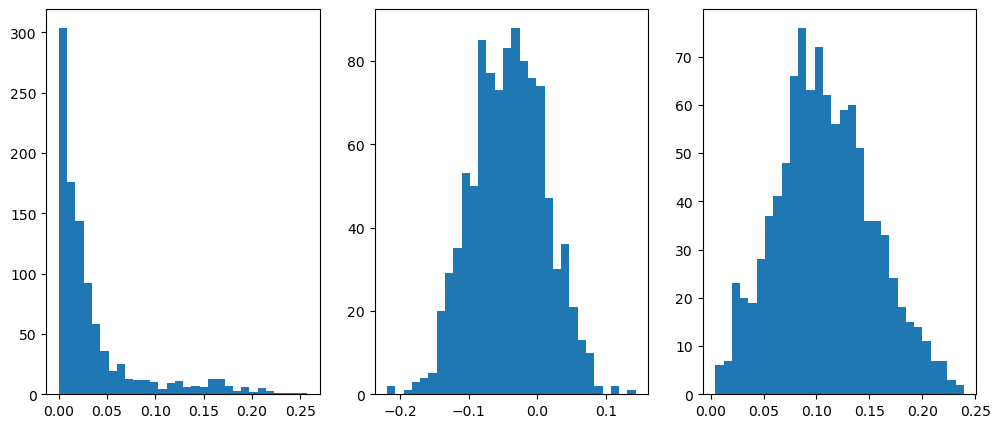

In [7]:
import numpy as np
from scipy.optimize import minimize, differential_evolution, minimize_scalar
from tqdm import tqdm
import matplotlib.pyplot as plt
import csv
import datetime

class UnifiedRobustEstimator:
    def __init__(self, delta_ji, n_models, alpha=0.1):
        self.delta_ji = delta_ji
        self.n_models = n_models
        self.alpha = alpha
        self.bounds = [(0.1, 0.9)] + [(0.1, 0.99)]*n_models
        self.current_p_observed = None
        self.p_initial = None
        self.gamma_initial = None

    def _physics_constraint(self, gamma):
        mean_dev = np.mean(np.abs(self.current_p_observed - 0.5))
        penalty_weight = 1000 * (1 + 5*mean_dev)
        penalty = 0
        
        for i in range(1, len(gamma)):
            diff = gamma[i] - gamma[i-1]
            penalty += penalty_weight * np.exp(-10*diff) if diff < 0 else 0
        
        boundary_penalty = np.sum(
            np.exp(10*(0.1 - gamma)) + 
            np.exp(10*(gamma - 0.99)))
        return penalty + boundary_penalty

    def _smart_initialization(self, p_observed):
        clean_obs = np.clip(p_observed, 0.15, 0.85)
        median = np.median(clean_obs)
        
        weights = 1.0 / (np.abs(clean_obs - median) + 1e-6)
        weights /= weights.sum()
        
        def weighted_quantile(values, quantile, weights):
            idx = np.argsort(values)
            sorted_values = values[idx]
            sorted_weights = weights[idx]
            cum_weights = np.cumsum(sorted_weights)
            return sorted_values[np.searchsorted(cum_weights, quantile)]
        
        q25 = weighted_quantile(clean_obs, 0.25, weights)
        q75 = weighted_quantile(clean_obs, 0.75, weights)
        
        gamma_base = np.linspace(q25, q75, self.n_models)
        p_candidates = [median, np.average(clean_obs, weights=weights)]
        return p_candidates, gamma_base

    def _smooth_clip(self, x, min_val, max_val):
        scale = 0.1
        return min_val + (max_val - min_val) * (1 + np.tanh((x - min_val)/(max_val - min_val)*np.pi - np.pi/2))/2

    def _objective_p_only(self, p):
        params = np.concatenate([[p], self.gamma_initial])
        return self._objective(params)

    def _objective(self, params):
        p = self._smooth_clip(params[0], 0.1, 0.9)
        gamma = np.array([self._smooth_clip(g, 0.1, 0.99) for g in params[1:]])
        
        p_reg = self.alpha * (p - self.p_initial)**2 if self.p_initial else 0
        
        exponents = np.power(gamma, self.delta_ji)
        denominators = (1 - exponents)*p + exponents
        denominators = np.clip(denominators, 1e-12, None)
        
        pred = p / denominators
        errors = pred - self.current_p_observed
        huber_loss = np.where(np.abs(errors) < 0.1, errors**2, 0.2*np.abs(errors))
        loss = np.mean(huber_loss)
        
        return loss + self._physics_constraint(gamma) + p_reg

    def fit(self, p_observed, n_restarts=5, warmup_rounds=5):
        self.current_p_observed = np.array(p_observed)
        
        p_candidates, gamma_base = self._smart_initialization(p_observed)
        self.gamma_initial = gamma_base
        
        res = minimize_scalar(
            lambda p: self._objective_p_only(p),
            bounds=(0.1, 0.9),
            method='Bounded',
            options={'maxiter': 100}
        )
        self.p_initial = res.x if res.success else np.median(p_candidates)
        best_p = self.p_initial
        
        init_pop = []
        for _ in range(15):
            rand_gamma = np.sort(gamma_base * np.random.uniform(0.8, 1.2, len(gamma_base)))
            init_pop.append(np.concatenate([[best_p], rand_gamma]))

        global_result = differential_evolution(
            self._objective,
            self.bounds,
            strategy='currenttobest1bin',
            popsize=20,
            maxiter=300,
            tol=1e-6,
            init=np.array(init_pop)
        )
        best_params = global_result.x
        best_loss = global_result.fun
        
        for _ in range(n_restarts):
            try:
                res = minimize(
                    self._objective,
                    x0=best_params * np.random.normal(1, 0.1, len(best_params)),
                    bounds=self.bounds,
                    method='SLSQP',
                    options={'maxiter': 300, 'ftol': 1e-6}
                )
                if res.success and res.fun < best_loss:
                    best_params = res.x
                    best_loss = res.fun
            except:
                continue
        
        final_res = minimize(
            self._objective,
            x0=best_params,
            bounds=self.bounds,
            method='L-BFGS-B',
            options={'maxiter': 200, 'ftol': 1e-8}
        )
        
        self.p_ = np.clip(final_res.x[0], 0.1, 0.9)
        self.gamma_ = np.clip(np.sort(final_res.x[1:]), 0.1, 0.99)
        return self

def run_stress_test(n_tests=1000):
    results = {'p_deltas': [], 'p_errors': [], 'gamma_errors': []}

    with open('intermediate_data.csv', 'w', newline='') as f:
        writer = csv.writer(f)
        header = [
            'test_id', 'timestamp', 'p_true',
            'gamma_true_1', 'gamma_true_2', 'gamma_true_3',
            'observed1_1', 'observed1_2', 'observed1_3',
            'observed2_1', 'observed2_2', 'observed2_3',
            'p1', 'p2', 'gamma_est_1', 'gamma_est_2', 'gamma_est_3',
            'p_delta', 'gamma_mae'
        ]
        writer.writerow(header)
    
    for test_id in tqdm(range(n_tests)):
        try:
            p_true = np.random.beta(2, 2)
            gamma_true = np.sort(np.random.uniform(0.5, 0.8, 3))
            
            observed1 = [p_true/((1-g**2)*p_true + g**2) + np.random.normal(0, 0.03) for g in gamma_true]
            estimator = UnifiedRobustEstimator(delta_ji=2, n_models=3)
            estimator.fit(np.clip(observed1, 0.1, 0.9))
            p1 = estimator.p_
            
            observed2 = [p_true/((1-g**2)*p_true + g**2) + np.random.normal(0, 0.03) for g in gamma_true]
            estimator.fit(np.clip(observed2, 0.1, 0.9))
            p2 = estimator.p_
            gamma_est2 = estimator.gamma_

            if np.isnan(p1) or np.isnan(p2):
                continue

            p_delta = abs(p2 - p1)
            gamma_mae = np.mean(np.abs(np.sort(gamma_est2) - gamma_true))
            
            results['p_deltas'].append(p_delta)
            results['p_errors'].append((p1 + p2)/2 - p_true)
            results['gamma_errors'].append(gamma_mae)

            with open('intermediate_data.csv', 'a', newline='') as f:
                writer = csv.writer(f)
                row = [
                    test_id, datetime.datetime.now().isoformat(), p_true,
                    *gamma_true,
                    *np.clip(observed1, 0.1, 0.9),
                    *np.clip(observed2, 0.1, 0.9),
                    p1, p2,
                    *np.sort(gamma_est2),
                    p_delta, gamma_mae
                ]
                writer.writerow(row)
                
        except Exception as e:
            print(f"测试{test_id}失败: {str(e)}")
            continue
    
    def safe_mean(data):
        return np.nan if len(data)==0 else np.nanmean(data)
    
    print(f"有效样本: {len(results['p_deltas'])}")
    print(f"p平均变化量: {safe_mean(results['p_deltas']):.4f}")
    print(f"p MAE: {safe_mean(np.abs(results['p_errors'])):.4f}")
    print(f"Gamma MAE: {safe_mean(results['gamma_errors']):.4f}")
    
    plt.figure(figsize=(12,5))
    plt.subplot(131).hist([x for x in results['p_deltas'] if not np.isnan(x)], bins=30)
    plt.subplot(132).hist([x for x in results['p_errors'] if not np.isnan(x)], bins=30)
    plt.subplot(133).hist([x for x in results['gamma_errors'] if not np.isnan(x)], bins=30)
    plt.show()

if __name__ == "__main__":
    run_stress_test(n_tests=1000)